In [24]:
import sys
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import random


# Prepare Environment

In [3]:
# Load pallets library

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))  # uncomment to run nb from 'pallets/nb'
# sys.path.append(os.path.abspath(os.getcwd()))                    # uncomment to run from project root

from pallets import images as I, datasets as DS, models as M, logging as L


In [4]:
# To GPU, or not to GPU
device = M.get_device(require_gpu=True)

# Logging
L.init_logger()


# Prepare Datasets

Create DataLoaders for both:

* the RGBA dataset
* the one-hot encoded dataset

In [5]:
# Demonstrate path from cpunk ID to list of the unique colors found
# in the image, eg. the image's color palette.

image = I.get_punk_tensor(0)
print(f"image shape: {image.shape}\n")

colors = I.one_image_colors(image)
print(f"total colors: {len(colors)}\n")
print(f"image colors:\n{colors}")


image shape: torch.Size([4, 24, 24])

total colors: 7

image colors:
tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.3137, 0.4863, 0.2000, 1.0000],
        [0.3647, 0.5451, 0.2627, 1.0000],
        [0.3725, 0.1137, 0.0353, 1.0000],
        [0.6824, 0.5451, 0.3804, 1.0000],
        [1.0000, 0.9647, 0.5569, 1.0000]])


### RGBA Dataset

In [5]:
# RGBA Dataset

dataset = DS.CPunksDataset(test_size=2000)
print(f"dataset size:   {len(dataset)}")
print(f"  - train size: {len(dataset.train_idx)}")
print(f"  - test size:  {len(dataset.test_idx)}\n")

train_sampler = SubsetRandomSampler(dataset.train_idx)
print(f"train sampler:  {len(train_sampler)}")
print(f"  - sample id:  {next(iter(train_sampler))}\n")

test_sampler = SubsetRandomSampler(dataset.test_idx)
print(f"test sampler:   {len(test_sampler)}")
print(f"  - sample id:  {next(iter(test_sampler))}\n")

# Put the RGBA things together
rgba_ds = (dataset, train_sampler, test_sampler)
rgba_models = (M.ae.NaiveRGBAAutoencoder, M.ae.ConvRGBAAutoencoder)


dataset size:   10000
  - train size: 8000
  - test size:  2000

train sampler:  8000
  - sample id:  9237

test sampler:   2000
  - sample id:  1626



### One Hot Dataset

1. Generate a one hot representation for all 222 colors.

2. Instantiate a mapper to go from each color to its one hot representation and back.

3. Create dataloader for punks that represents its color data as one hot vectors.

In [28]:
# Unique colors for all punks

all_colors = I.get_punk_colors()
print(f"colors found: {len(all_colors)}")


colors found: 222


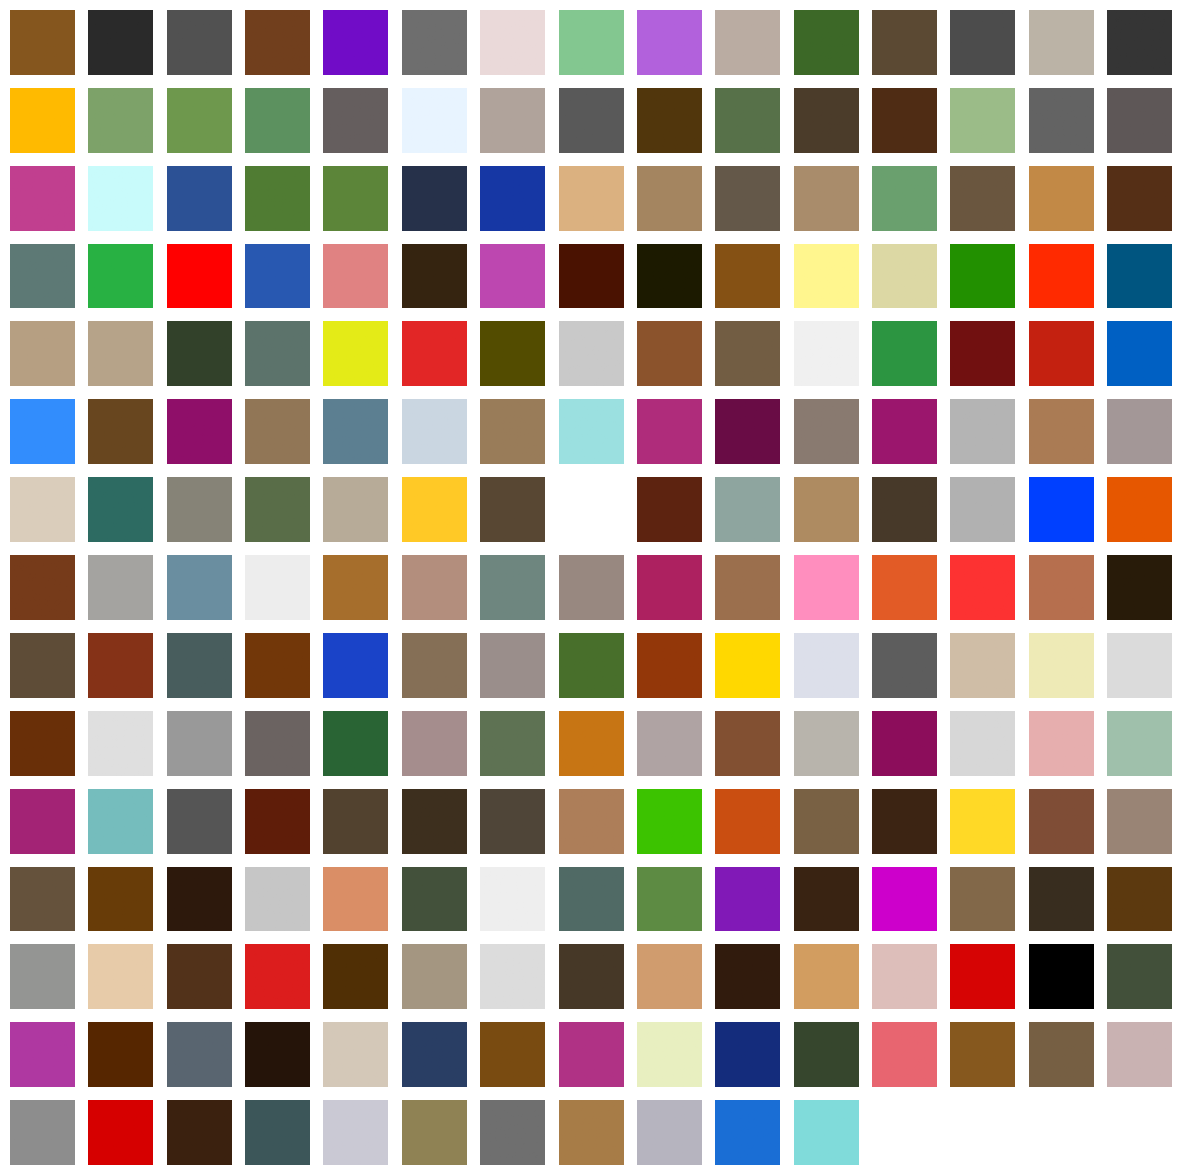

In [46]:
color_imgs = [np.full((24, 24, 4), c) for c in all_colors]
(x,y) = (15,15)
fig = plt.figure(figsize=(x,y))
i=1
for c in random.sample(color_imgs, 222):
    fig.add_subplot(x, y, i)
    plt.imshow(c)
    plt.axis('off')
    i=i+1


In [7]:
# Mapper from color to one hot

mapper = DS.ColorOneHotMapper(all_colors)

# Start with a color
test_color = all_colors[2]
print(f"color:\n{test_color}\n")

# Convert color to one hot
test_one_hot = mapper.to_one_hot(test_color)
print(f"one-hot encoded:\n{test_one_hot}\n")

# Convert one hot back to original color
retrieved_color = mapper.to_color(test_one_hot)
print(f"back as color:\n{retrieved_color}")


color:
tensor([0.0000, 0.2510, 1.0000, 1.0000])

one-hot encoded:
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

one hot encoded: torch.Size([222, 24, 24])
rgba encoded:    torch.Size([4, 24, 24])


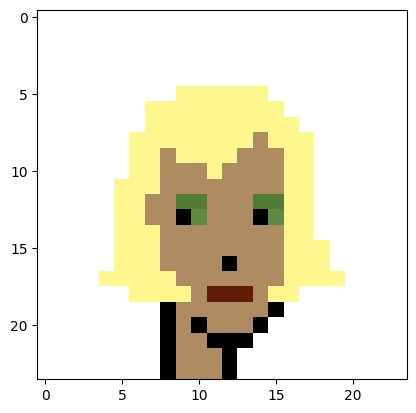

In [8]:
# Convert entire image to one hot encoded and back

one_hot_encoded_image = DS.rgba_to_one_hot(image, mapper)
print(f"one hot encoded: {one_hot_encoded_image.shape}")

restored = DS.one_hot_to_rgba(one_hot_encoded_image, mapper)
print(f"rgba encoded:    {restored.shape}")

# Show an image after going to one hot encoding and back
plt.imshow(to_pil_image(restored))
plt.show()


In [9]:
# One Hot Dataset

dataset = DS.OneHotEncodedImageDataset(mapper, test_size=2000)
print(f"dataset size:   {len(dataset)}")
print(f"  - train size: {len(dataset.train_idx)}")
print(f"  - test size:  {len(dataset.test_idx)}\n")

train_sampler = SubsetRandomSampler(dataset.train_idx)
print(f"train sampler:  {len(train_sampler)}")
print(f"  - sample id:  {next(iter(train_sampler))}\n")

test_sampler = SubsetRandomSampler(dataset.test_idx)
print(f"test sampler:   {len(test_sampler)}")
print(f"  - sample id:  {next(iter(test_sampler))}\n")

# Put the one hot things together
one_hot_ds = (dataset, train_sampler, test_sampler)
one_hot_models = (M.ae.NaiveOneHotAutoencoder, M.ae.ConvOneHotAutoencoder)


dataset size:   10000
  - train size: 8000
  - test size:  2000

train sampler:  8000
  - sample id:  5933

test sampler:   2000
  - sample id:  331



# Train Model

In [10]:
# Model: Naive RGBA
# autoencoder = M.ae.NaiveRGBAAutoencoder()
# criterion = torch.nn.MSELoss()
# (dataset, train_sampler, test_sampler) = rgba_ds

# Model: Conv RGBA
# autoencoder = M.ae.ConvRGBAAutoencoder()
# criterion = torch.nn.MSELoss()
# (dataset, train_sampler, test_sampler) = rgba_ds

# Model: Naive One Hot
# autoencoder = M.ae.NaiveOneHotAutoencoder()
# criterion = torch.nn.CrossEntropyLoss()
# (dataset, train_sampler, test_sampler) = one_hot_ds

# Model: Conv One Hot
autoencoder = M.ae.ConvOneHotAutoencoder()
criterion = torch.nn.CrossEntropyLoss()
(dataset, train_sampler, test_sampler) = one_hot_ds


In [11]:
# Prepare dataset

batch_size = 32

train_loader = DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler,
)

test_loader = DataLoader(
    dataset, batch_size=batch_size, sampler=test_sampler,
)

train_punk = next(iter(train_loader))
print(f"train punk: {train_punk.shape}")

test_punk = next(iter(test_loader))
print(f"test punk:  {test_punk.shape}")


train punk: torch.Size([32, 222, 24, 24])
test punk:  torch.Size([32, 222, 24, 24])


In [12]:
# Cue training montage

train_losses, test_losses = M.ae.train(
    device, autoencoder, criterion, train_loader, test_loader,
    learn_rate=1e-3, epochs=5
)


epoch [1/5]
  - train loss: 0.9869925975203514
  - test loss:  0.23700452134722755
epoch [2/5]
  - train loss: 0.0983364215567708
  - test loss:  0.034757541196923404
epoch [3/5]
  - train loss: 0.018301887525245548
  - test loss:  0.010511612785714013
epoch [4/5]
  - train loss: 0.006421952511183917
  - test loss:  0.005328022026722985
epoch [5/5]
  - train loss: 0.0033537068939767777
  - test loss:  0.0033841081894934177


In [13]:
# M.save(autoencoder, 'conv-onehot.pkl')


# Model Output to Image

In [14]:
# autoencoder = M.load('naive-onehot.pkl')
# autoencoder.to(device)


In [15]:
# Reconstruct `train_punk`

print(train_punk.shape)

reconstructed = autoencoder(train_punk)
print(reconstructed.shape)
reconstructed = reconstructed.detach().cpu()
some_image = reconstructed[0]

# From one hot back to 24x24 image with RGBA colors
if isinstance(autoencoder, one_hot_models):
    some_image = DS.one_hot_to_rgba(some_image, mapper)

print(some_image.shape)



torch.Size([32, 222, 24, 24])
torch.Size([32, 222, 24, 24])
torch.Size([4, 24, 24])


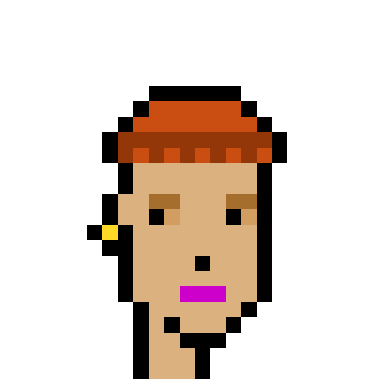

In [16]:
pil_image = to_pil_image(some_image.clone().detach())

plt.imshow(pil_image)
plt.axis('off')
plt.show()



# Tests

In [17]:
train_losses


[0.9869925975203514,
 0.0983364215567708,
 0.018301887525245548,
 0.006421952511183917,
 0.0033537068939767777]

In [18]:
test_losses


[0.23700452134722755,
 0.034757541196923404,
 0.010511612785714013,
 0.005328022026722985,
 0.0033841081894934177]

<function matplotlib.pyplot.show(close=None, block=None)>

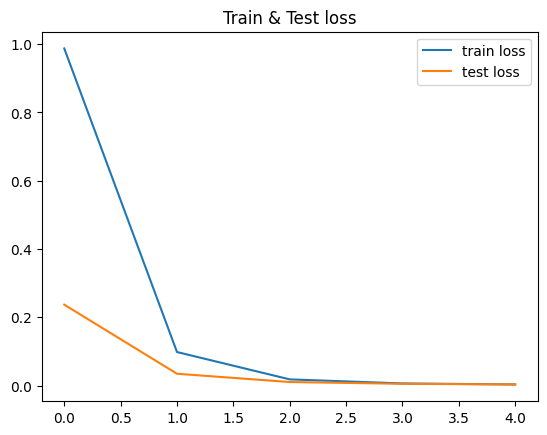

In [19]:
# plt.figure(figsize=(10,5))
plt.title("Train & Test loss")
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show
